In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
sheet_id = "19_PDN8T2OjMV49tQTTblBPPtt6C_9oWg-yeSjqRYjFA"
sheet_name = "Sheet1"

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

df = pd.read_csv(url)
df.head()

,url,date,price_inr,price_thb
0,https://pricehistory.app/p/samsung-galaxy-s24-...,2024-01-18,79999.0,35199.56
1,https://pricehistory.app/p/samsung-galaxy-s24-...,2024-01-20,79999.0,35199.56
2,https://pricehistory.app/p/samsung-galaxy-s24-...,2024-01-24,79999.0,35199.56
3,https://pricehistory.app/p/samsung-galaxy-s24-...,2024-01-28,79999.0,35199.56
4,https://pricehistory.app/p/samsung-galaxy-s24-...,2024-01-29,79999.0,35199.56


In [3]:
df.tail()

,url,date,price_inr,price_thb
500,https://pricehistory.app/p/samsung-galaxy-s24-...,2025-11-12,49800.0,21912.00
501,https://pricehistory.app/p/samsung-galaxy-s24-...,2025-11-14,48750.0,21450.00
502,https://pricehistory.app/p/samsung-galaxy-s24-...,2025-11-16,48715.0,21434.60
503,https://pricehistory.app/p/samsung-galaxy-s24-...,2025-11-19,48999.0,21559.56
504,https://pricehistory.app/p/samsung-galaxy-s24-...,2025-11-20,50250.0,22110.00


In [4]:
print('Total number of days present in the dataset: ',df.shape[0])
print('Total number of fields present in the dataset: ',df.shape[1])

Total number of days present in the dataset:  505
Total number of fields present in the dataset:  4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   url        505 non-null    object 
 1   date       505 non-null    object 
 2   price_inr  505 non-null    float64
 3   price_thb  505 non-null    float64
dtypes: float64(2), object(2)
memory usage: 15.9+ KB


In [6]:
df.describe()

,price_inr,price_thb
count,505.000000,505.000000
mean,61436.122871,27031.894063
std,10967.530560,4825.713446
min,46500.000000,20460.000000
25%,51938.000000,22852.720000
50%,57550.000000,25322.000000
75%,67999.000000,29919.560000
max,79999.000000,35199.560000


In [7]:
print('Null Values:',df.isnull().values.sum())

Null Values: 0


In [8]:
df.shape

(505, 4)

In [9]:
sd=df.iloc[0][1]
ed=df.iloc[-1][1]


print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 2024-01-18
Ending Date 2025-11-20


/tmp/ipython-input-610901595.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sd=df.iloc[0][1]
/tmp/ipython-input-610901595.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ed=df.iloc[-1][1]


In [10]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [11]:
prices = df['price_inr'].values.reshape(-1,1)
dates = df['date'].values

In [12]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(prices)

In [13]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_scaled, seq_length)

In [14]:
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(396, 10, 1) (396, 1)
(99, 10, 1) (99, 1)


In [15]:
alpha = 0.2
last_prices_train = pd.Series(X_train[:, -1, 0])
smoothed_train = last_prices_train.ewm(alpha=alpha, adjust=False).mean()

threshold = 0.4
pct_change = smoothed_train.pct_change().abs().fillna(0)
keep_idx = pct_change <= threshold

X_train_clean = X_train[keep_idx.values]
y_train_clean = y_train[keep_idx.values]

print("Before cleaning:", X_train.shape)
print("After cleaning (train only):", X_train_clean.shape)

Before cleaning: (396, 10, 1)
After cleaning (train only): (396, 10, 1)


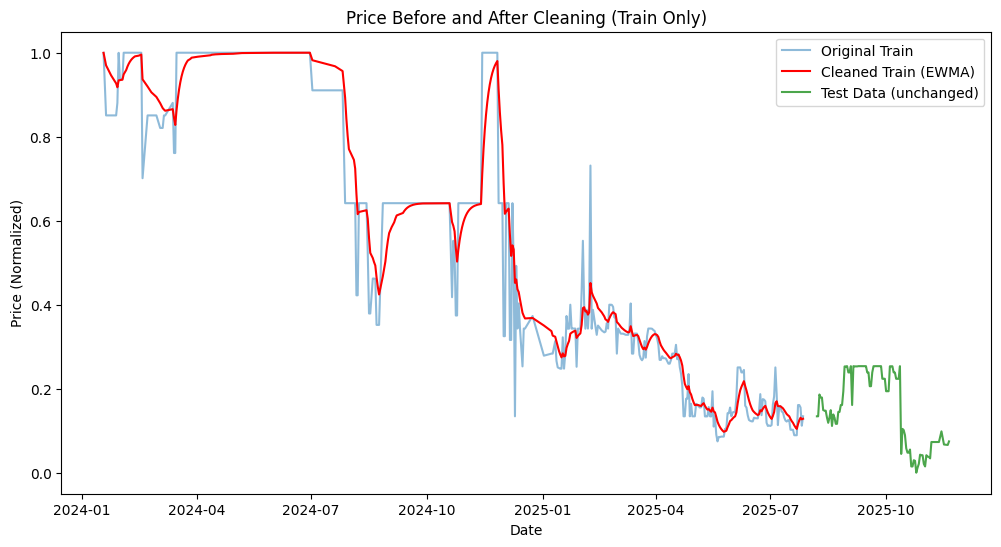

In [16]:
plt.figure(figsize=(12,6))
plt.plot(df['date'][:len(last_prices_train)], last_prices_train, label='Original Train', alpha=0.5)
plt.plot(df['date'][:len(last_prices_train)][keep_idx.values], smoothed_train[keep_idx.values],
         label='Cleaned Train (EWMA)', color='red')

test_dates = df['date'][split+seq_length:]
plt.plot(test_dates, X_test[:, -1, 0], label='Test Data (unchanged)', color='green', alpha=0.7)

plt.title("Price Before and After Cleaning (Train Only)")
plt.xlabel("Date")
plt.ylabel("Price (Normalized)")
plt.legend()
plt.grid(False)
plt.show()

In [17]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train_clean, y_train_clean,
    validation_data=(X_test, y_test),
    epochs=199,
    batch_size=32,
    verbose=1
)

model.save("gru_model_latest.h5")
print("Saved model as gru_model_latest.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 0.3090 - val_loss: 0.0076
Epoch 2/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1248 - val_loss: 0.0074
Epoch 3/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0226 - val_loss: 0.0250
Epoch 4/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - val_loss: 0.0084
Epoch 5/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0112 - val_loss: 0.0069
Epoch 6/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - val_loss: 0.0022
Epoch 7/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - val_loss: 0.0018
Epoch 8/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 0.0017
Epoch 9/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - val_loss: 0.0020
Epoch 10/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0016
Epoch 11/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - val_loss: 0.0016
Epoch 12/199
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 

Saved model as gru_model_latest.h5


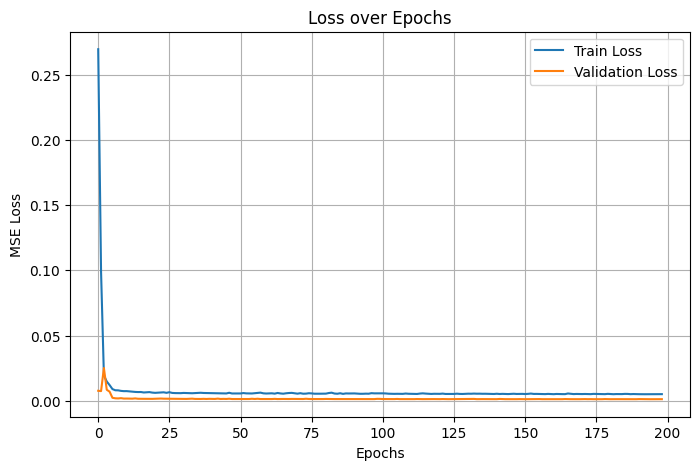

In [18]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
y_train_pred = model.predict(X_train_clean)
y_test_pred = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


In [20]:
y_train_actual = scaler.inverse_transform(y_train_clean)
y_test_actual = scaler.inverse_transform(y_test)
y_train_pred_actual = scaler.inverse_transform(y_train_pred)
y_test_pred_actual = scaler.inverse_transform(y_test_pred)

In [21]:
train_mse = mean_squared_error(y_train_actual, y_train_pred_actual)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_actual, y_train_pred_actual)

test_mse = mean_squared_error(y_test_actual, y_test_pred_actual)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_actual, y_test_pred_actual)

In [22]:
print(f"Train RMSE: {train_rmse:.2f}, R2: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")

Train RMSE: 2357.56, R2: 0.95
Test RMSE: 1143.00, R2: 0.84


In [23]:
mape = np.mean(np.abs((y_test_actual - y_test_pred_actual) / y_test_actual)) * 100
print(f"Average Error (%): {mape:.2f}%")

Average Error (%): 1.59%


In [24]:
inr_to_thb = 0.44

mae_inr = np.mean(np.abs(y_test_actual - y_test_pred_actual))
mae_thb = mae_inr * inr_to_thb

print(f"Average Error: {mae_inr:.2f} INR")
print(f"Average Error: {mae_thb:.2f} THB")

Average Error: 821.77 INR
Average Error: 361.58 THB


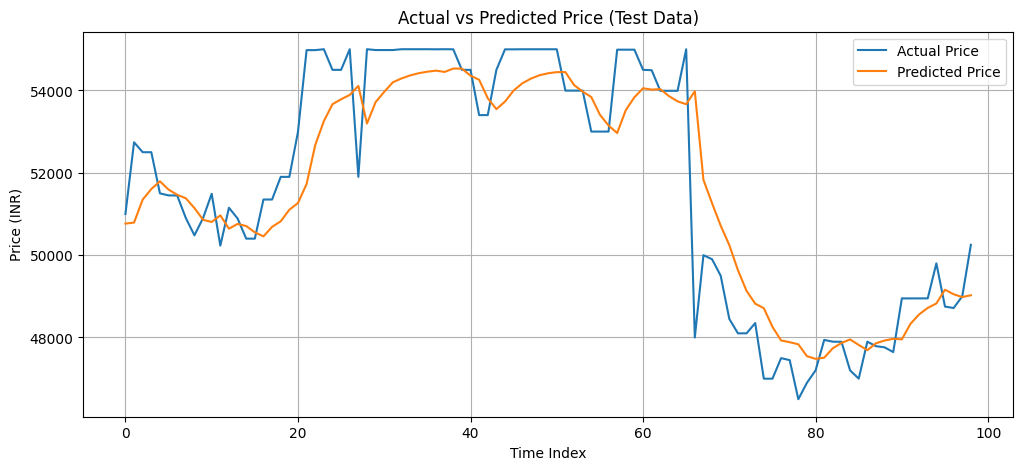

In [25]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(y_test_pred_actual, label='Predicted Price')
plt.title("Actual vs Predicted Price (Test Data)")
plt.xlabel("Time Index")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.show()